In [ ]:
import os
import numpy as np
import cv2
from scipy.stats import kurtosis, weibull_min
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import joblib


In [ ]:
import cv2
import os
import numpy as np

def extract_keyframes_by_scene(video_paths, output_dir, motion_threshold=1.5, fps_sampling=5):
    os.makedirs(output_dir, exist_ok=True)

    for video_path in video_paths:
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        video_output_dir = os.path.join(output_dir, video_name)
        os.makedirs(video_output_dir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        frame_interval = frame_rate // fps_sampling

        prev_frame = None
        keyframe_index = 0
        frame_index = 0

        while cap.isOpened():
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to grayscale for scene change detection
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Scene change detection based on absolute difference
            if prev_frame is not None:
                diff = cv2.absdiff(prev_frame, gray_frame)
                mean_diff = np.mean(diff)

                # Detect scene change or significant motion
                if mean_diff > motion_threshold:
                    keyframe_path = os.path.join(video_output_dir, f'keyframe_{keyframe_index}.jpg')
                    cv2.imwrite(keyframe_path, frame)
                    keyframe_index += 1

            prev_frame = gray_frame
            frame_index += frame_interval

        cap.release()

# Example usage
video_files = [
    '/content/drive/MyDrive/VideoMP4/Elevator.mp4',
    '/content/drive/MyDrive/VideoMP4/NightVisit.mp4',
    '/content/drive/MyDrive/VideoMP4/PlatMe.mp4',
    '/content/drive/MyDrive/VideoMP4/Stucco.mp4',
    '/content/drive/MyDrive/VideoMP4/SushiNoh.mp4',
    '/content/drive/MyDrive/VideoMP4/TheBottom.mp4',
    '/content/drive/MyDrive/VideoMP4/TheChair.mp4'
]

extract_keyframes_by_scene(video_files, 'keyframes', motion_threshold=1.5, fps_sampling=5)


In [ ]:
def color_variance_in_luv(keyframes_dir):
    variances = []
    for root, dirs, files in os.walk(keyframes_dir):
        for filename in files:
            if filename.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, filename))
                luv_img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
                L_channel, u_channel, v_channel = cv2.split(luv_img)
                cov_matrix = np.cov([L_channel.flatten(), u_channel.flatten(), v_channel.flatten()])
                generalized_variance = np.linalg.det(cov_matrix)
                variances.append(generalized_variance)
    return np.mean(variances) if variances else np.nan

def lighting_key_features(keyframes_dir):
    brightness, shadows = [], []
    shadow_threshold = 0.18
    for root, dirs, files in os.walk(keyframes_dir):
        for filename in files:
            if filename.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, filename))
                luv_img = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
                L_channel = luv_img[:, :, 0]
                brightness.append(np.median(L_channel))
                shadow_ratio = np.sum(L_channel < shadow_threshold * 255) / L_channel.size
                shadows.append(shadow_ratio)
    return np.mean(brightness), np.mean(shadows)

def hsv_color_features(keyframes_dir):
    h_means, s_means, v_means = [], [], []
    h_vars, s_vars, v_vars = [], [], []
    h_kurts, s_kurts, v_kurts = [], [], []
    for root, dirs, files in os.walk(keyframes_dir):
        for filename in files:
            if filename.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, filename))
                hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                H, S, V = cv2.split(hsv_img)
                h_means.append(np.mean(H))
                s_means.append(np.mean(S))
                v_means.append(np.mean(V))
                h_vars.append(np.var(H))
                s_vars.append(np.var(S))
                v_vars.append(np.var(V))
                h_kurts.append(kurtosis(H.flatten(), nan_policy='omit'))
                s_kurts.append(kurtosis(S.flatten(), nan_policy='omit'))
                v_kurts.append(kurtosis(V.flatten(), nan_policy='omit'))
    return (np.mean(h_means), np.mean(s_means), np.mean(v_means),
            np.mean(h_vars), np.mean(s_vars), np.mean(v_vars),
            np.mean(h_kurts), np.mean(s_kurts), np.mean(v_kurts))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def texture_analysis(keyframes_dir):
    beta_params, gamma_params = [], []
    for root, dirs, files in os.walk(keyframes_dir):
        for filename in files:
            if filename.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, filename), cv2.IMREAD_GRAYSCALE)
                hist, _ = np.histogram(img.flatten(), bins=256, density=True)
                params = weibull_min.fit(hist, floc=0)
                beta_params.append(params[0])
                gamma_params.append(params[1])
    return np.mean(beta_params), np.mean(gamma_params)

def spatial_features(keyframes_dir, grid_size=3):
    spatial_means, spatial_vars = [], []
    for root, dirs, files in os.walk(keyframes_dir):
        for filename in files:
            if filename.endswith('.jpg'):
                img = cv2.imread(os.path.join(root, filename))
                h, w, _ = img.shape
                grid_h, grid_w = h // grid_size, w // grid_size
                for i in range(grid_size):
                    for j in range(grid_size):
                        grid = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
                        spatial_means.append(np.mean(grid))
                        spatial_vars.append(np.var(grid))
    return np.mean(spatial_means), np.mean(spatial_vars)

In [ ]:
def extract_all_features(keyframes_dir):
    features = []
    features.append(color_variance_in_luv(keyframes_dir))
    features.extend(lighting_key_features(keyframes_dir))
    features.extend(hsv_color_features(keyframes_dir))
    features.extend(texture_analysis(keyframes_dir))
    features.extend(spatial_features(keyframes_dir))
    return features

# Extract features for each trailer
def extract_features_for_training(trailer_dirs):
    features = []
    for trailer_dir in trailer_dirs:
        feature_vector = extract_all_features(trailer_dir)
        features.append(feature_vector)
    return np.array(features)

In [ ]:
from sklearn.impute import SimpleImputer
def ocsvm_score(estimator, X):
    # Fit the model on X
    estimator.fit(X)
    # Get the decision function values (higher means more normal)
    scores = estimator.decision_function(X)
    # Return the mean score as a metric
    return np.mean(scores)

# Manual hyperparameter tuning function for One-Class SVM
def tune_svm_hyperparameters(X_scaled):
    best_score = -np.inf
    best_model = None

    # Define parameter grid
    nu_values = [0.01, 0.1, 0.5]
    kernels = ['rbf', 'linear']
    gamma_values = ['scale', 0.001, 0.01]

    for nu in nu_values:
        for kernel in kernels:
            for gamma in gamma_values:
                # Create and fit the model with current parameters
                oc_svm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
                score = ocsvm_score(oc_svm, X_scaled)

                # Check if this is the best score so far
                if score > best_score:
                    best_score = score
                    best_model = oc_svm

    return best_model

# Main pipeline for training and saving the model
trailer_dirs = [
    '/content/keyframes/Elevator',
    '/content/keyframes/NightVisit',
    '/content/keyframes/PlatMe',
    '/content/keyframes/Stucco',
    '/content/keyframes/SushiNoh',
    '/content/keyframes/TheBottom',
    '/content/keyframes/TheChair'
]

# Load and extract features
X = extract_features_for_training(trailer_dirs)

# Impute NaN values in feature matrix
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Tune and train the One-Class SVM model manually
oc_svm_model = tune_svm_hyperparameters(X_scaled)

# Save the model, scaler, and imputer
joblib.dump(oc_svm_model, 'video2SVC1.pkl')
joblib.dump(scaler, 'video2SVCScaler.pkl')
joblib.dump(imputer, 'video2SVCImputer.pkl')

print("Imputer, scaler, and One-Class SVM model saved after manual hyperparameter tuning.")

Imputer, scaler, and One-Class SVM model saved after manual hyperparameter tuning.


In [ ]:
import pandas as pd
import joblib
import numpy as np
import cv2
import shutil
import os

best_oc_svm_model = joblib.load('/content/video2SVC1.pkl')
scaler = joblib.load('/content/video2SVCScaler.pkl')
imputer = joblib.load('/content/video2SVCImputer.pkl')

timestamps_df = pd.read_csv('/content/bleepAudioCSV.csv')  # Adjust to your actual path
movie_file = '/content/drive/MyDrive/VideoMP4/bleep.mp4'  # Path to your movie file

def extract_frames(movie_file, timestamps):
    frames = []
    video = cv2.VideoCapture(movie_file)

    for _, row in timestamps.iterrows():
        start_time = row['Start Time (s)']
        video.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)
        success, frame = video.read()
        if success:
            frames.append(frame)

    video.release()
    return frames

def extract_all_features(keyframes_dir):
    features = []
    features.append(color_variance_in_luv(keyframes_dir))
    features.extend(lighting_key_features(keyframes_dir))
    features.extend(hsv_color_features(keyframes_dir))
    features.extend(texture_analysis(keyframes_dir))
    features.extend(spatial_features(keyframes_dir))
    return features

def extract_features_for_training(trailer_dirs):
    features = []
    for trailer_dir in trailer_dirs:
        feature_vector = extract_all_features(trailer_dir)
        features.append(feature_vector)
    return np.array(features)

def extract_features_from_frame(frame):
    temp_dir = 'temp_frame_dir'
    os.makedirs(temp_dir, exist_ok=True)
    frame_path = os.path.join(temp_dir, 'frame.jpg')
    cv2.imwrite(frame_path, frame)
    features = extract_all_features(temp_dir)
    shutil.rmtree(temp_dir)
    return features

frames = extract_frames(movie_file, timestamps_df)

X_new = np.array([extract_features_from_frame(frame) for frame in frames])

if np.any(np.isnan(X_new)):
    print("NaNs found in new data, imputing...")
    X_new_imputed = imputer.transform(X_new)
else:
    X_new_imputed = X_new

X_new_scaled = scaler.transform(X_new_imputed)

# Get decision function scores
decision_scores = best_oc_svm_model.decision_function(X_new_scaled)
print(decision_scores)

mean = np.mean(X_new_imputed)
#threshold = -0.2
threshold = np.percentile(decision_scores, 40)
predictions = np.where(decision_scores > threshold, 1, -1)

# Update the DataFrame with predictions
timestamps_df['trailer_worthy'] = predictions

# Filter the trailer-worthy segments
trailer_worthy_df = timestamps_df[timestamps_df['trailer_worthy'] == 1]

# Save or print the results
if not trailer_worthy_df.empty:
    print(trailer_worthy_df)
    trailer_worthy_df.to_csv('trailer_worthy_timestamps.csv', index=False)
else:
    print("No trailer-worthy timestamps were found.")


NaNs found in new data, imputing...
[-0.50310823 -0.23426163 -0.23503229 -0.46604326 -0.17769681 -0.18041636
 -0.16265737 -0.17287134 -0.16634307 -0.21833333 -0.20927557]
   Start Time (s)  End Time (s)  trailer_worthy
6             145           150               1
8             155           160               1


In [ ]:
import pandas as pd
import joblib
import numpy as np
import cv2
import shutil
import os
from sklearn.metrics.pairwise import cosine_similarity

best_oc_svm_model = joblib.load('/content/video2SVC1.pkl')
scaler = joblib.load('/content/video2SVCScaler.pkl')
imputer = joblib.load('/content/video2SVCImputer.pkl')

timestamps_df = pd.read_csv('/content/bleepAudioCSV.csv')
movie_file = '/content/drive/MyDrive/VideoMP4/bleep.mp4'

def extract_frames(movie_file, timestamps):
    frames = []
    video = cv2.VideoCapture(movie_file)

    for _, row in timestamps.iterrows():
        start_time = row['Start Time (s)']
        video.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)
        success, frame = video.read()
        if success:
            frames.append(frame)

    video.release()
    return frames

def extract_all_features(keyframes_dir):
    features = []
    features.append(color_variance_in_luv(keyframes_dir))
    features.extend(lighting_key_features(keyframes_dir))
    features.extend(hsv_color_features(keyframes_dir))
    features.extend(texture_analysis(keyframes_dir))
    features.extend(spatial_features(keyframes_dir))
    return features

def extract_features_from_frame(frame):
    temp_dir = 'temp_frame_dir'
    os.makedirs(temp_dir, exist_ok=True)
    frame_path = os.path.join(temp_dir, 'frame.jpg')
    cv2.imwrite(frame_path, frame)
    features = extract_all_features(temp_dir)
    shutil.rmtree(temp_dir)
    return features

frames = extract_frames(movie_file, timestamps_df)

X_new = np.array([extract_features_from_frame(frame) for frame in frames])

if np.any(np.isnan(X_new)):
    X_new_imputed = imputer.transform(X_new)
else:
    X_new_imputed = X_new
X_new_scaled = scaler.transform(X_new_imputed)

decision_scores = best_oc_svm_model.decision_function(X_new_scaled)
print(decision_scores)
threshold = -0.175  # Define your threshold here based on your model's expected score range

trailer_worthy_indices = np.where(decision_scores > threshold)[0]

timestamps_df['trailer_worthy'] = np.where(timestamps_df.index.isin(trailer_worthy_indices), 1, -1)

trailer_worthy_df = timestamps_df[timestamps_df['trailer_worthy'] == 1]

if not trailer_worthy_df.empty:
    print(trailer_worthy_df)
    trailer_worthy_df.to_csv('trailer_worthy_timestamps.csv', index=False)
else:
    print("No trailer-worthy timestamps were found.")


[-0.18324577 -0.1472413  -0.11968282 -0.17327332 -0.17031253 -0.19777058
 -0.19325221 -0.19547393 -0.09646021 -0.18102525 -0.21781493 -0.1339795
 -0.22412773 -0.19043045 -0.15541807 -0.19581462 -0.18301892 -0.42242189
 -0.22670822 -0.19264111 -0.11361681 -0.21850392 -0.15775797 -0.22428688
 -0.1881553  -0.1713296  -0.1945485  -0.13592891 -0.24146169]
    Start Time (s)  End Time (s)  trailer_worthy
1              455           460               1
2              335           340               1
3              440           445               1
4              315           320               1
8              350           355               1
11             285           290               1
14              90            95               1
20             340           345               1
22              65            70               1
25             150           155               1
27             310           315               1


In [ ]:
# MMAS - 10 to 5
# Bleep A - 500 s to 50 s (10 segements) |  V

In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
import pandas as pd

# Load timestamps from CSV
csv_file_path = '/content/trailer_worthy_timestamps.csv'
timestamps_df = pd.read_csv(csv_file_path)

# Load the movie file
movie_file_path = '/content/drive/MyDrive/VideoMP4/bleep.mp4'
movie = VideoFileClip(movie_file_path)

# Initialize a list to hold video clips
clips = []

# Extract clips based on the timestamps
for _, row in timestamps_df.iterrows():
    start_time = row["Start Time (s)"]
    end_time = row["End Time (s)"]

    if not (start_time == 315 and end_time == 320):
        clip = movie.subclip(start_time, end_time)
        clips.append(clip)

# Concatenate all clips into one final trailer
final_trailer = concatenate_videoclips(clips, method="compose")

# Write the final trailer to a file, ensuring audio is included
output_path = "bleep2.mp4"
final_trailer.write_videofile(output_path, codec="libx264", audio_codec="aac")

print(f"Trailer-worthy compilation saved as {output_path}")


Moviepy - Building video bleep2.mp4.
Moviepy - Writing video bleep2.mp4



Moviepy - Done !
Moviepy - video ready bleep2.mp4
Trailer-worthy compilation saved as bleep2.mp4


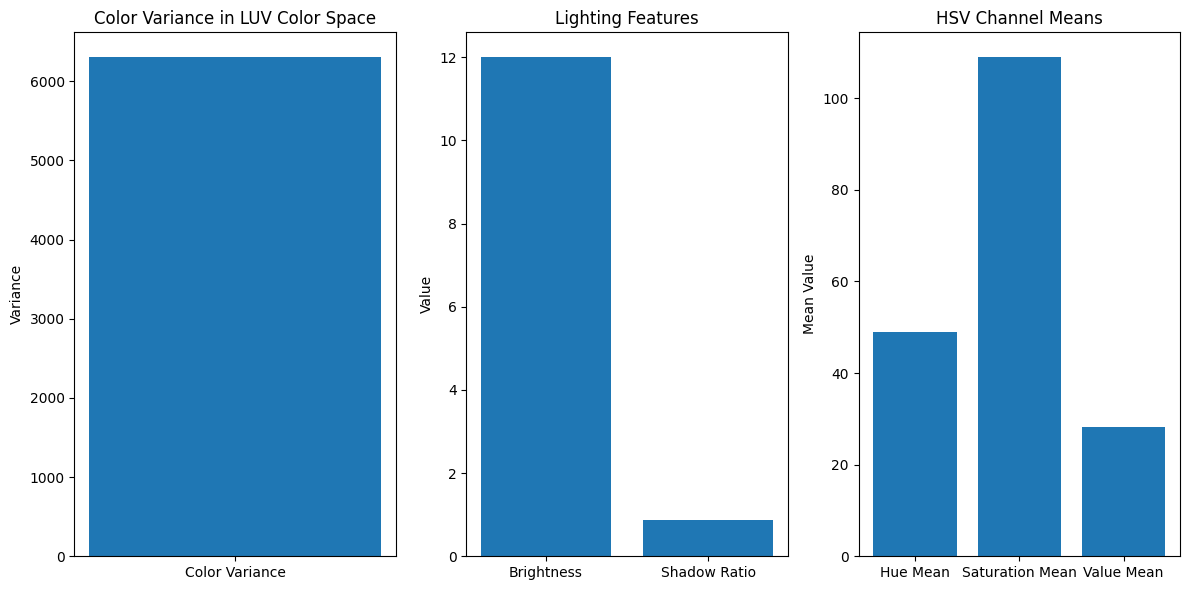

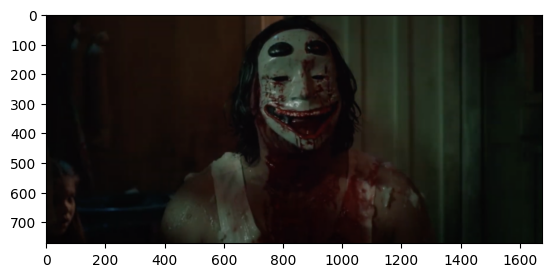

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from PIL import Image

def color_variance_in_luv(image):
    luv_img = cv2.cvtColor(image, cv2.COLOR_BGR2Luv)
    L_channel, u_channel, v_channel = cv2.split(luv_img)
    cov_matrix = np.cov([L_channel.flatten(), u_channel.flatten(), v_channel.flatten()])
    generalized_variance = np.linalg.det(cov_matrix)
    return generalized_variance

def lighting_key_features(image):
    luv_img = cv2.cvtColor(image, cv2.COLOR_BGR2Luv)
    L_channel = luv_img[:, :, 0]
    brightness = np.median(L_channel)
    shadow_threshold = 0.18
    shadow_ratio = np.sum(L_channel < shadow_threshold * 255) / L_channel.size
    return brightness, shadow_ratio

def hsv_color_features(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_img)

    h_mean = np.mean(H)
    s_mean = np.mean(S)
    v_mean = np.mean(V)

    h_var = np.var(H)
    s_var = np.var(S)
    v_var = np.var(V)

    h_kurt = kurtosis(H.flatten(), nan_policy='omit')
    s_kurt = kurtosis(S.flatten(), nan_policy='omit')
    v_kurt = kurtosis(V.flatten(), nan_policy='omit')

    return (h_mean, s_mean, v_mean, h_var, s_var, v_var, h_kurt, s_kurt, v_kurt)

image_path = '/content/img1.png'
image = cv2.imread(image_path)

# Extract features
color_variance = color_variance_in_luv(image)
brightness, shadow_ratio = lighting_key_features(image)
hsv_features = hsv_color_features(image)

# Visualization
plt.figure(figsize=(12, 6))

# Color Variance
plt.subplot(1, 3, 1)
plt.bar(['Color Variance'], [color_variance])
plt.ylabel('Variance')
plt.title('Color Variance in LUV Color Space')

# Brightness and Shadows
plt.subplot(1, 3, 2)
plt.bar(['Brightness', 'Shadow Ratio'], [brightness, shadow_ratio])
plt.ylabel('Value')
plt.title('Lighting Features')

# HSV Features
h_mean, s_mean, v_mean, h_var, s_var, v_var, h_kurt, s_kurt, v_kurt = hsv_features
plt.subplot(1, 3, 3)
plt.bar(['Hue Mean', 'Saturation Mean', 'Value Mean'], [h_mean, s_mean, v_mean])
plt.ylabel('Mean Value')
plt.title('HSV Channel Means')
plt.tight_layout()
plt.show()

plt.imshow(Image.open(image_path))

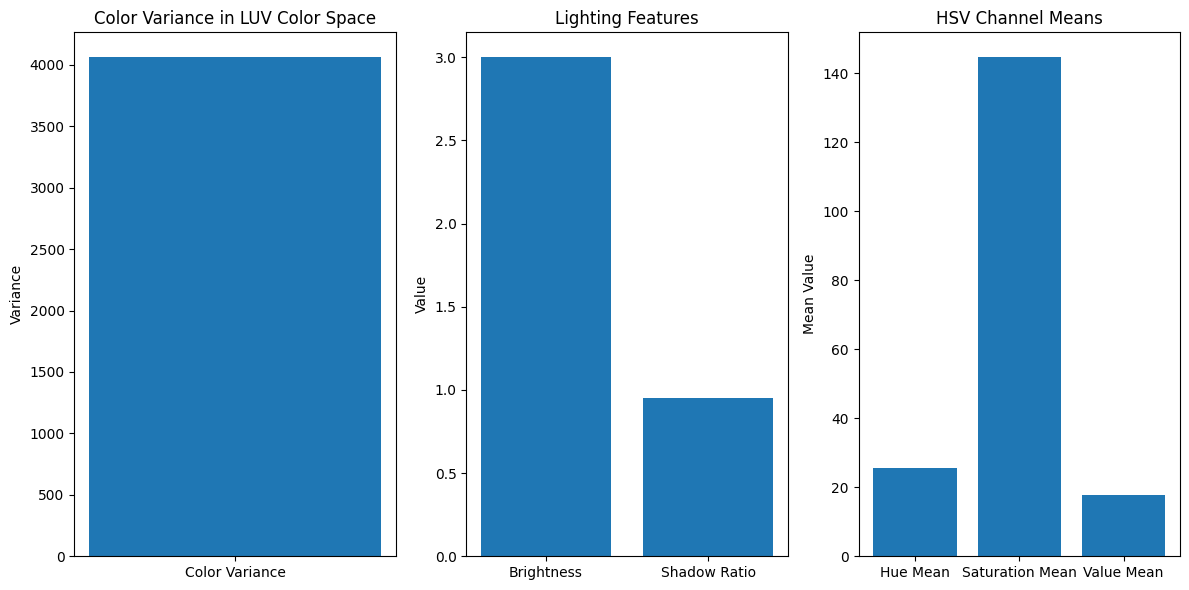

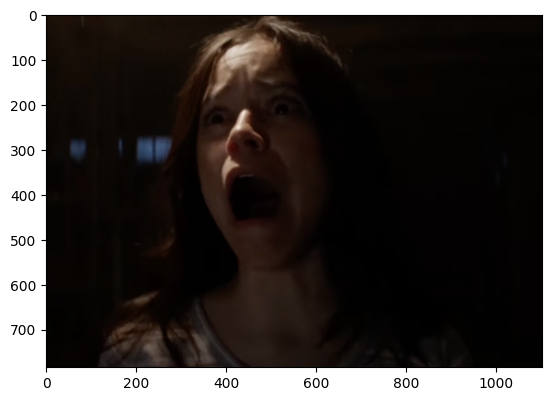

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from PIL import Image

def color_variance_in_luv(image):
    luv_img = cv2.cvtColor(image, cv2.COLOR_BGR2Luv)
    L_channel, u_channel, v_channel = cv2.split(luv_img)
    cov_matrix = np.cov([L_channel.flatten(), u_channel.flatten(), v_channel.flatten()])
    generalized_variance = np.linalg.det(cov_matrix)
    return generalized_variance

def lighting_key_features(image):
    luv_img = cv2.cvtColor(image, cv2.COLOR_BGR2Luv)
    L_channel = luv_img[:, :, 0]
    brightness = np.median(L_channel)
    shadow_threshold = 0.18
    shadow_ratio = np.sum(L_channel < shadow_threshold * 255) / L_channel.size
    return brightness, shadow_ratio

def hsv_color_features(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_img)

    h_mean = np.mean(H)
    s_mean = np.mean(S)
    v_mean = np.mean(V)

    h_var = np.var(H)
    s_var = np.var(S)
    v_var = np.var(V)

    h_kurt = kurtosis(H.flatten(), nan_policy='omit')
    s_kurt = kurtosis(S.flatten(), nan_policy='omit')
    v_kurt = kurtosis(V.flatten(), nan_policy='omit')

    return (h_mean, s_mean, v_mean, h_var, s_var, v_var, h_kurt, s_kurt, v_kurt)

image_path = '/content/img2.png'
image = cv2.imread(image_path)

# Extract features
color_variance = color_variance_in_luv(image)
brightness, shadow_ratio = lighting_key_features(image)
hsv_features = hsv_color_features(image)

# Visualization
plt.figure(figsize=(12, 6))

# Color Variance
plt.subplot(1, 3, 1)
plt.bar(['Color Variance'], [color_variance])
plt.ylabel('Variance')
plt.title('Color Variance in LUV Color Space')

# Brightness and Shadows
plt.subplot(1, 3, 2)
plt.bar(['Brightness', 'Shadow Ratio'], [brightness, shadow_ratio])
plt.ylabel('Value')
plt.title('Lighting Features')

# HSV Features
h_mean, s_mean, v_mean, h_var, s_var, v_var, h_kurt, s_kurt, v_kurt = hsv_features
plt.subplot(1, 3, 3)
plt.bar(['Hue Mean', 'Saturation Mean', 'Value Mean'], [h_mean, s_mean, v_mean])
plt.ylabel('Mean Value')
plt.title('HSV Channel Means')
plt.tight_layout()
plt.show()

plt.imshow(Image.open(image_path))